In [2]:
import os
import json
import pandas as pd
import numpy as np
import re
import pvlib
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from pvanalytics.features.clipping import geometric

Define directories

In [3]:
base_dir = os.path.join(os.path.expanduser("~"), 'pv-snow-analysis')
data_dir = os.path.join(base_dir, 'data')
data_path = os.path.join(data_dir, 'data.csv')
snow_path = os.path.join(data_dir, 'snow.csv')
mask_path = os.path.join(data_dir, 'mask.csv')
config_path = os.path.join(data_dir, 'config.json')

Load in utility data

In [4]:
data = pd.read_csv(data_path, index_col='Timestamp')
data.set_index(pd.DatetimeIndex(data.index,ambiguous='infer'), inplace=True)
data = data[~data.index.duplicated()]

Explore the dataset

In [5]:
print('Utility-scale dataset')
print('Start: {}'.format(data.index[0]))
print('End: {}'.format(data.index[-1]))
print('Frequency: {}'.format(data.index.inferred_freq))
print('Columns : ' + ', '.join(data.columns))

Utility-scale dataset
Start: 2022-01-05 00:00:00
End: 2022-01-10 23:45:00
Frequency: 15T
Columns : POA [W/m²], INV1 CB1 Voltage [V], INV1 CB2 Voltage [V], INV1 CB3 Voltage [V], INV2 CB1 Voltage [V], INV2 CB2 Voltage [V], INV2 CB3 Voltage [V], INV3 CB1 Voltage [V], INV3 CB2 Voltage [V], INV3 CB3 Voltage [V], Module Temp [C], Ambient Temp [C], INV1 CB1 Current [A], INV1 CB2 Current [A], INV1 CB3 Current [A], INV2 CB1 Current [A], INV2 CB2 Current [A], INV2 CB3 Current [A], INV3 CB1 Current [A], INV3 CB2 Current [A], INV3 CB3 Current [A], INV1 AC Power [W], INV2 AC Power [W], INV3 AC Power [W], apparent_zenith, zenith, apparent_elevation, elevation, azimuth, equation_of_time, aoi


In [6]:
data.between_time('8:00', '16:00').head()

,POA [W/m²],INV1 CB1 Voltage [V],INV1 CB2 Voltage [V],INV1 CB3 Voltage [V],INV2 CB1 Voltage [V],INV2 CB2 Voltage [V],INV2 CB3 Voltage [V],INV3 CB1 Voltage [V],INV3 CB2 Voltage [V],INV3 CB3 Voltage [V],...,INV1 AC Power [W],INV2 AC Power [W],INV3 AC Power [W],apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,aoi
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-05 08:00:00,6.341689,519.8452,530.4985,516.1296,538.2413,536.2116,511.0573,524.2973,536.7109,513.8563,...,0.537790,0.520845,0.214897,84.584208,84.737275,5.415792,5.262725,127.465770,-5.393607,89.985936
2022-01-05 08:15:00,9.501580,557.3946,561.6168,556.8163,572.9615,581.6041,550.8978,560.9218,568.2010,559.8977,...,0.747047,0.754061,0.460859,82.470088,82.586004,7.529912,7.413996,130.194453,-5.398253,86.671975
2022-01-05 08:30:00,17.475320,603.6666,602.7585,603.7078,608.5931,618.8737,593.1352,605.7507,607.8348,611.5270,...,1.234256,1.201519,0.926125,80.427405,80.520797,9.572595,9.479203,133.003064,-5.402898,83.385309
2022-01-05 08:45:00,27.683840,636.7689,637.2244,636.6835,634.3732,641.5668,626.8843,636.4623,638.1898,642.2595,...,1.875128,1.806173,1.548036,78.470802,78.549251,11.529198,11.450749,135.896621,-5.407542,80.129640
2022-01-05 09:00:00,54.138590,668.2807,673.6044,668.9899,664.8721,649.3834,660.5640,669.7222,670.6644,671.3162,...,3.752917,3.663049,3.489472,76.611424,76.679329,13.388576,13.320671,138.879302,-5.412185,76.909223


Identify and correct non-physical values

In [7]:
# Identify current, voltage, and AC power columns
dc_voltage_cols = [c for c in data.columns if 'Voltage' in c]
dc_current_cols = [c for c in data.columns if 'Current' in c]
ac_power_cols = [c for c in data.columns if 'AC' in c]

# Set negative or Nan current, voltage, AC power values to zero. This is
# allows us to calculate losses later.

data.loc[:, dc_voltage_cols] = np.maximum(data[dc_voltage_cols], 0)
data.loc[:, dc_current_cols] = np.maximum(data[dc_current_cols], 0)
data.loc[:, ac_power_cols] = np.maximum(data[ac_power_cols], 0)

data.loc[:, dc_voltage_cols] = data[dc_voltage_cols].replace({np.nan: 0, None: 0})
data.loc[:, dc_current_cols] = data[dc_current_cols].replace({np.nan: 0, None: 0})
data.loc[:, ac_power_cols] = data[ac_power_cols].replace({np.nan: 0, None: 0})

Load information about the system configuration

In [8]:
# Load in system configuration parameters (dict)
with open(config_path) as json_data:
    config = json.load(json_data)

print(f'Inverter AC power rating: {config['max_ac']} kW')
print(f'Inverter MPPT range: {config['min_dcv']} V - {config['max_dcv']} V')
print(f'There are {config['num_mods_per_str']['INV1 CB1']} modules connected in series in each string, and there are {config['num_str_per_cb']['INV1 CB1']} strings connected in parallel in each combiner')

Inverter AC power rating: 60.0 kW
Inverter MPPT range: 540.0 V - 850.0 V
There are 18 modules connected in series in each string, and there are 4 strings connected in parallel in each combiner


Explore DC data

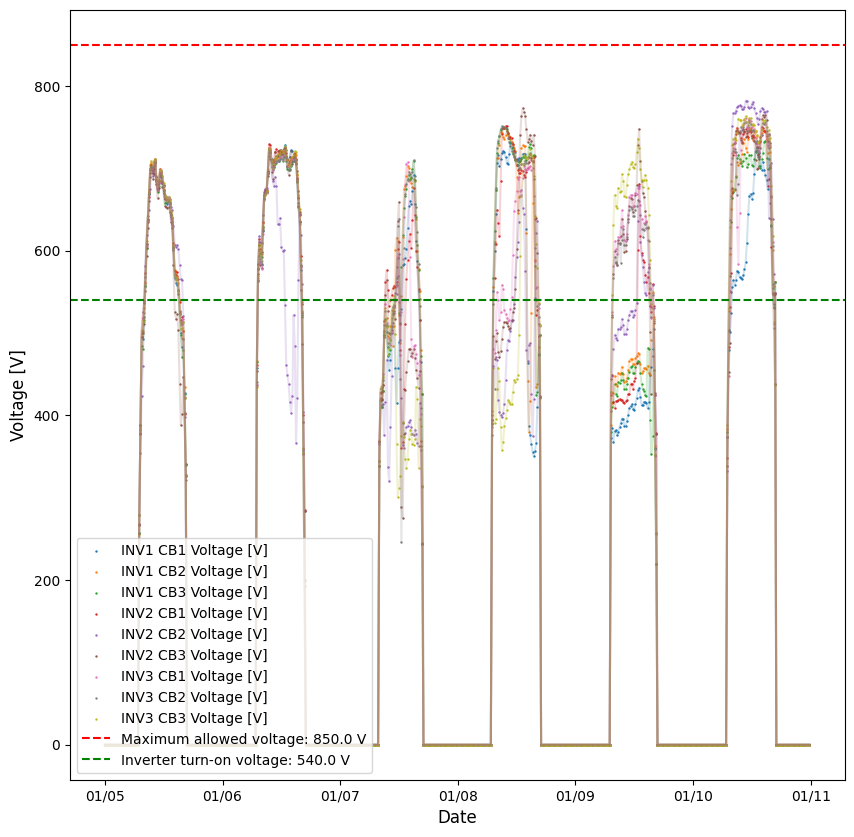

In [9]:
# Plot DC voltage for each combiner input relative to inverter nameplate limits

fig, ax = plt.subplots(figsize=(10,10))                  
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
for v in dc_voltage_cols:
    ax.scatter(data.index, data[v], s=0.5, label=v)
    ax.plot(data.index, data[v], alpha=0.2)
ax.axhline(float(config['max_dcv']), c='r', ls='--', label='Maximum allowed voltage: {} V'.format(config['max_dcv']))
ax.axhline(float(config['min_dcv']), c='g', ls='--', label='Inverter turn-on voltage: {} V'.format(config['min_dcv']))
ax.set_xlabel('Date', fontsize='large')
ax.set_ylabel('Voltage [V]', fontsize='large')
ax.legend(loc='lower left')

Explore AC data

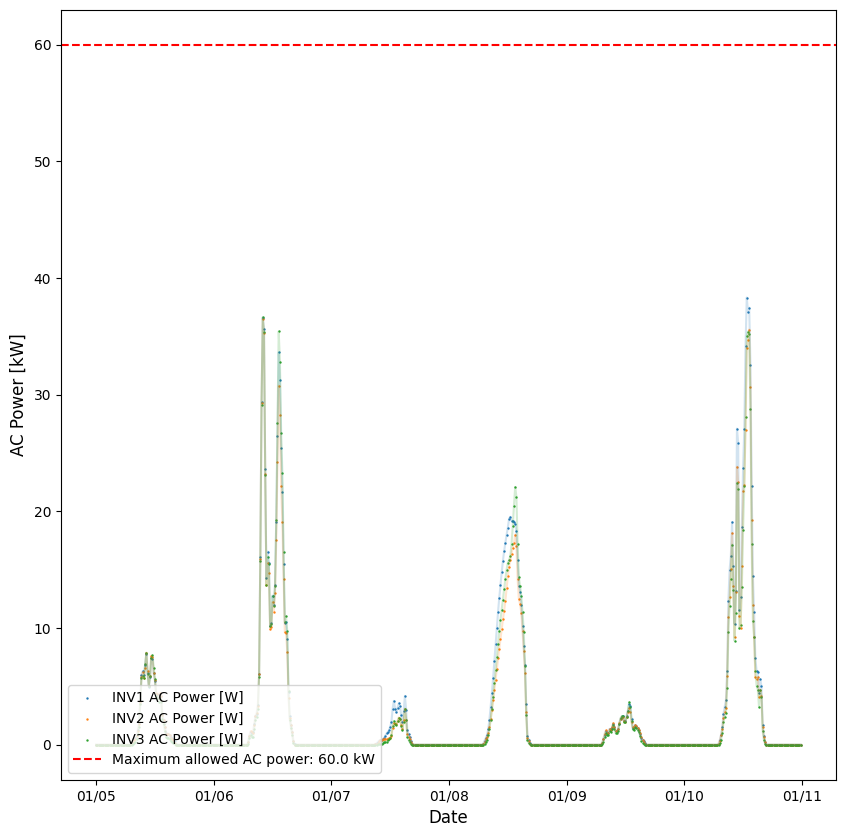

In [10]:
# Plot AC power relative to inverter nameplate limits

fig, ax = plt.subplots(figsize=(10,10))                  
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
for a in ac_power_cols:
    ax.scatter(data.index, data[a], s=0.5, label=a)
    ax.plot(data.index, data[a], alpha=0.2)
ax.axhline(float(config['max_ac']), c='r', ls='--', label='Maximum allowed AC power: {} kW'.format(config['max_ac']))
ax.set_xlabel('Date', fontsize='large')
ax.set_ylabel('AC Power [kW]', fontsize='large')
ax.legend(loc='lower left')

Identify periods where the system is operating off of its maximum power point, and correct

In [11]:
ac_power_cols_repeated = ac_power_cols + ac_power_cols + ac_power_cols
for v, i, a in zip(dc_voltage_cols, dc_current_cols, ac_power_cols_repeated):

    # Data where V > MPPT rating
    data.loc[(data[v] > float(config['max_dcv'])), v] = np.nan
    data.loc[(data[v] > float(config['max_dcv'])), i] = np.nan
    data.loc[(data[v] > float(config['max_dcv'])), a] = np.nan
    
    # Data where V < MPPT turn-on voltage
    data.loc[data[v] < float(config['min_dcv']), v] = 0
    data.loc[data[v] < float(config['min_dcv']), i] = 0
    data.loc[data[v] < float(config['min_dcv']), a] = 0
    
    # Data where system is at Voc
    data.loc[data[i] == 0, v] = 0

    # Data where inverter is clipping based on AC power
    mask1 = data[a] > float(config['max_ac'])
    mask2 = geometric(ac_power=data[a], freq='15T')
    mask3 = np.logical_or(mask1.values, mask2.values)

    data.loc[mask3, v] = np.nan
    data.loc[mask3, i] = np.nan
    data.loc[mask3, a] = np.nan

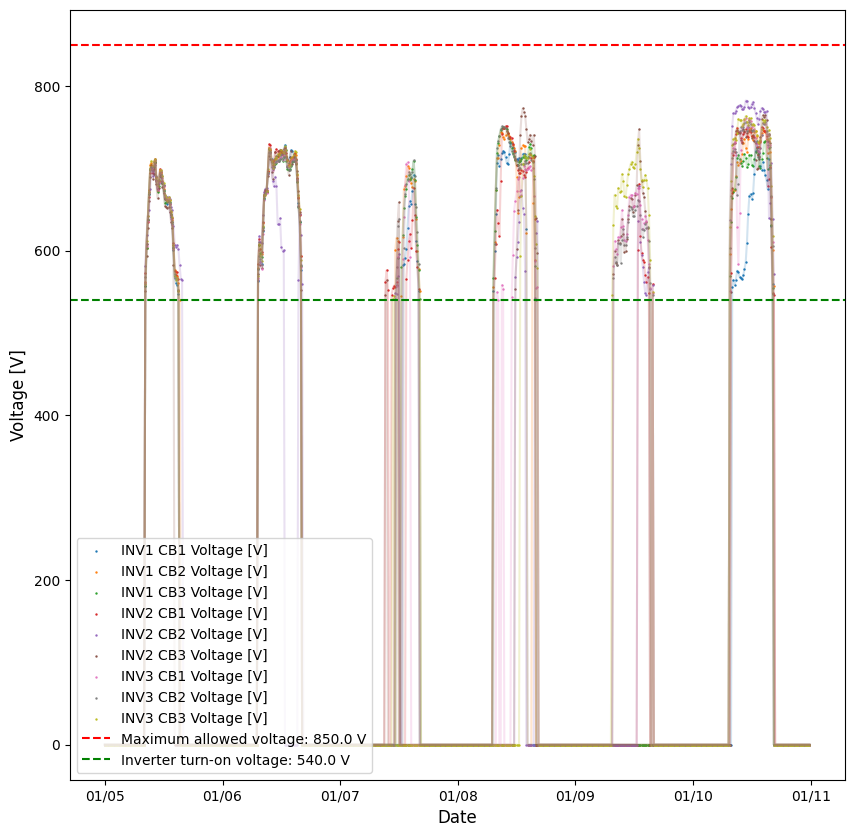

In [12]:
# Plot DC voltage for each combiner input relative to inverter nameplate limits

fig, ax = plt.subplots(figsize=(10,10))                  
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
for v in dc_voltage_cols:
    ax.scatter(data.index, data[v], s=0.5, label=v)
    ax.plot(data.index, data[v], alpha=0.2)
ax.axhline(float(config['max_dcv']), c='r', ls='--', label='Maximum allowed voltage: {} V'.format(config['max_dcv']))
ax.axhline(float(config['min_dcv']), c='g', ls='--', label='Inverter turn-on voltage: {} V'.format(config['min_dcv']))
ax.set_xlabel('Date', fontsize='large')
ax.set_ylabel('Voltage [V]', fontsize='large')
ax.legend(loc='lower left')

In [13]:
'''
Load in and apply horizon profiling created using approach described in [1]

[1] J. L. Braid and B. G. Pierce, "Horizon Profiling Methods for Photovoltaic Arrays,"
2023 IEEE 50th Photovoltaic Specialists Conference (PVSC), San Juan, PR, USA, 2023,
pp. 1-7, doi: 10.1109/PVSC48320.2023.10359914.

'''

horizon_mask = pd.read_csv(mask_path, index_col='Unnamed: 0')

def apply_mask(mask, x ,y):
    if np.isnan(x) == False:
        if y > mask.at[int(np.floor(x)), '0']:
            return False
        else:
            return True
    else:
        return np.nan

data.loc[:, 'Horizon Mask'] = data.apply(lambda x: apply_mask(horizon_mask, x['azimuth'], x['elevation']), axis = 1)
data = data[data['Horizon Mask'] == False]

In [14]:
# %% Define SAPM coefficients for modeling transmission

coeffs = config['sapm_coeff']

In [40]:
"""
Model cell temperature using procedure outlined in Eqn. 12 of [1]
and model effective irradiance using Eqn. 23 of [2].

[1] King, D.L., E.E. Boyson, and J.A. Kratochvil, Photovoltaic Array
Performance Model, SAND2004-3535, Sandia National Laboratories,
Albuquerque, NM, 2004.
[2] B. H. King, C. W. Hansen, D. Riley, C. D. Robinson and L. Pratt,
“Procedure to Determine Coefficients for the Sandia Array Performance
Model (SAPM)," SAND2016-5284, June 2016.
"""

irrad_ref = 1000
data['Effective irradiance [suns]'] = data['POA [W/m²]']/irrad_ref
data['Cell Temp [C]'] = data['Module Temp [C]'] + 3*(data['Effective irradiance [suns]'])


Text(0.5, 0, 'Date')

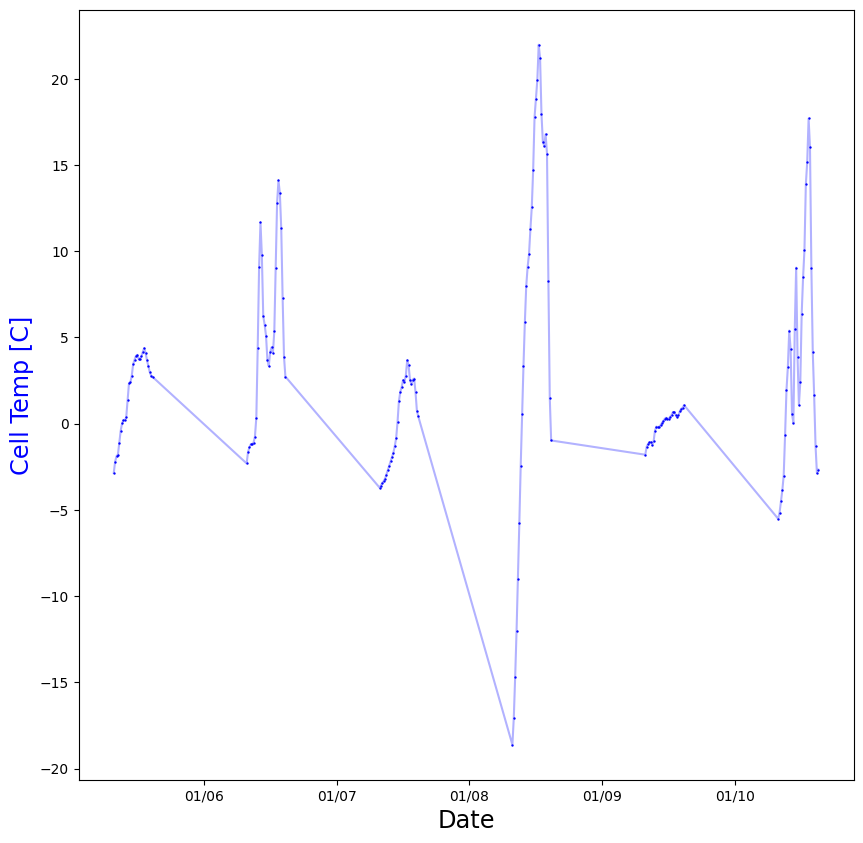

In [41]:
# %% Plot cell temperature
fig, ax = plt.subplots(figsize=(10,10))                        
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.scatter(data.index, data['Cell Temp [C]'], s=0.5, c='b')
ax.plot(data.index, data['Cell Temp [C]'], alpha=0.3, c='b')
ax.set_ylabel('Cell Temp [C]', c='b', fontsize='xx-large')
ax.set_xlabel('Date', fontsize='xx-large')

In [42]:
def _a_func(temp_cell, imp0, c1, alpha_imp, temp_ref=25):
    return imp0*c1*(1 + alpha_imp*(temp_cell - temp_ref))

def _b_func(temp_cell, imp0, c0, alpha_imp, temp_ref=25):
    return imp0*c0*(1 + alpha_imp*(temp_cell - temp_ref))

def _c_func(current):
    return -current

def _solve_quadratic_eqn(a, b, c):
    """
    Solves for x given ax**2 + bx + c = 0. Only
    returns solution where x = (-b + sqrt(discriminant))/(2a) where the
    disciminant is b**2 - 4ac.

    Parameters
    ----------
    a : array
    b : array
    c : array

    Returns
    -------
    x : array

    """

    assert((len(a) == len(b)) & (len(a) == len(c)))
    discriminant = np.square(b) - 4*a*c
    x = (-b + np.sqrt(discriminant))/(2*a)
    return x

def get_irradiance(temp_cell,
                     current, imp0, c0,
                     c1, alpha_imp,
                     temp_ref=25):
    """
    Solves Eqn. 2 from [1] for a modeled effective irradiance

    Parameters
    ----------
    temp_cell : array
        Temperature of cells inside module [degrees C]
    current : array
        Measured current [A] at the resolution of a single module
    measured_e_e : array
        Effective irradiance to which the PV cells in the module respond
        measured by a heated plane-of-array pyranometer [suns]
    imp0 : float
        Namplate short-circuit current[A]
    c0, c1 : float
        Empirically determined coefficients relating Imp to effective
        irradiance
    alpha_imp : float
        Normalized temperature coefficient for Isc, (1/°C).
    temp_ref : float
        Reference cell temperature [degrees C]

    Returns
    -------
    effective_irradiance : array
        Effective irradiance [suns]


    [1] King, D.L., E.E. Boyson, and J.A. Kratochvil, Photovoltaic Array
    Performance Model, SAND2004-3535, Sandia National Laboratories,
    Albuquerque, NM, 2004.
    
    """

    a = _a_func(temp_cell, imp0, c1, alpha_imp, temp_ref)
    b = _b_func(temp_cell, imp0, c0, alpha_imp, temp_ref)
    c = _c_func(current)
    effective_irradiance = _solve_quadratic_eqn(a, b, c)
    return effective_irradiance

def get_transmission(measured_e_e, modeled_e_e, current):
    
    """
    Divides modeled effective irradiance by measured effective irradiance
    to obtain an effective transmission [1].

    Parameters
    ----------
    measured_e_e : array
        Effective irradiance to which the PV cells in the module respond
        measured by a heated plane-of-array pyranometer [suns]
    modeled_e_e : array
        Effective irradiance modeled using model_irradiance() [suns]
    current : array
        Measured current [A] at the resolution of a single module
    Returns
    -------
    T : array
        Effective transmission [dimensionless]

    [2] E. C. Cooper, J. L. Braid and L. M. Burnham, "Identifying the
    Electrical Signature of Snow in Photovoltaic Inverter Data," 2023 IEEE
    50th Photovoltaic Specialists Conference (PVSC), San Juan, PR, USA, 2023,
    pp. 1-5, doi: 10.1109/PVSC48320.2023.10360065.
    """
    
    T = modeled_e_e/measured_e_e
    T[np.argwhere(np.isnan(current))] = np.nan
    T[np.argwhere(current == 0)] = 0
    T[T < 0] = np.nan
    T[T > 1] = 1

    return T

In [45]:
# %% Demonstrate transmission calculation
j = 0
v = dc_voltage_cols[j]
i = dc_current_cols[j]

# Used to get key for configuration dict
matched = re.match(r'INV(\d+) CB(\d+)', i)
inv_cb = matched.group(0)

# Number of strings connected in parallel to combiner.
# Used to scale measured current down to the resolution
# of a single string connected in series, which should
# be the same current as is 
i_scaling_factor = int(config['num_str_per_cb'][f'{inv_cb}'])

modeled_e_e = get_irradiance(data['Cell Temp [C]'].values,
                     data[i].values/i_scaling_factor,
                     coeffs['Impo'], coeffs['C0'], coeffs['C1'],
                     coeffs['Aimp'])
T = get_transmission(data['Effective irradiance [suns]'].values, modeled_e_e, data[i].values/i_scaling_factor)
name_T = inv_cb + ' Transmission'
data[name_T] = T

Text(0.5, 0, 'Date + Time')

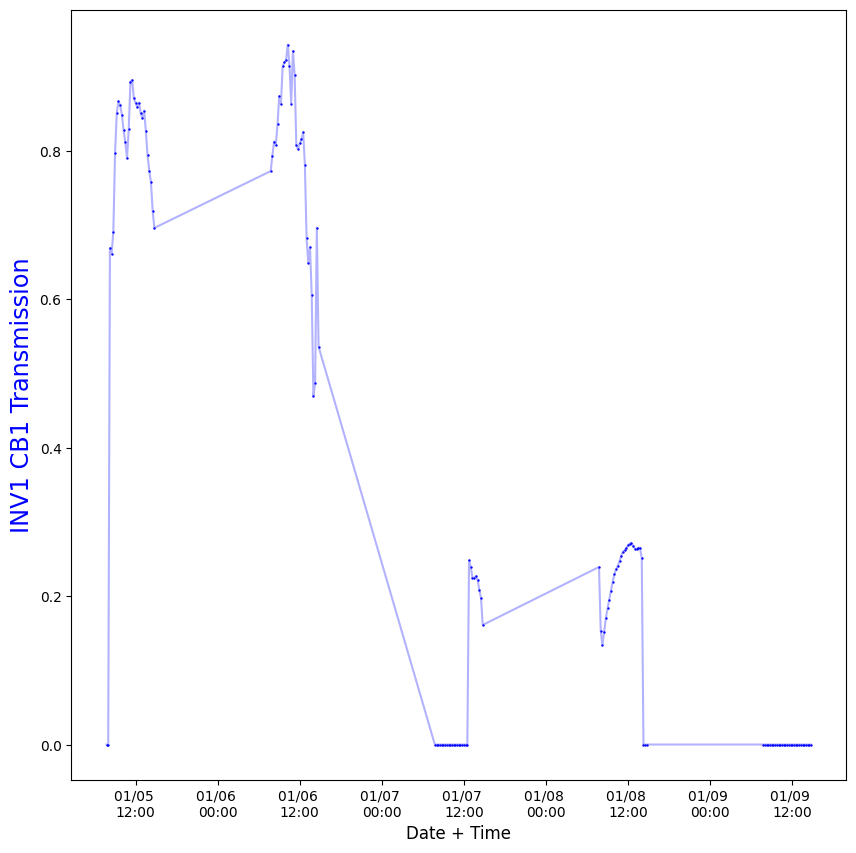

In [46]:
# %% Plot transmission
fig, ax = plt.subplots(figsize=(10,10))                             
date_form = DateFormatter("%m/%d \n%H:%M")
ax.xaxis.set_major_formatter(date_form)
temp = data[: '2022-01-09 17:45:00']

ax.scatter(temp.index, temp[name_T], s=0.5, c='b')
ax.plot(temp.index, temp[name_T], alpha=0.3, c='b')
ax.set_ylabel(name_T, c='b', fontsize='xx-large')
ax.set_xlabel('Date + Time', fontsize='large')

In [47]:
# %% Model voltage using calculated transmission
v_scaling_factor = int(config['num_mods_per_str'][inv_cb])
modeled_vmp = pvlib.pvsystem.sapm(data['POA [W/m²]']*T,
                                  data['Cell Temp [C]'],
                                  coeffs)['v_mp']

name_modeled_vmp = inv_cb + ' Predicted Vmp from Imp'
data[name_modeled_vmp] = v_scaling_factor*modeled_vmp

Text(0.5, 0, 'Date')

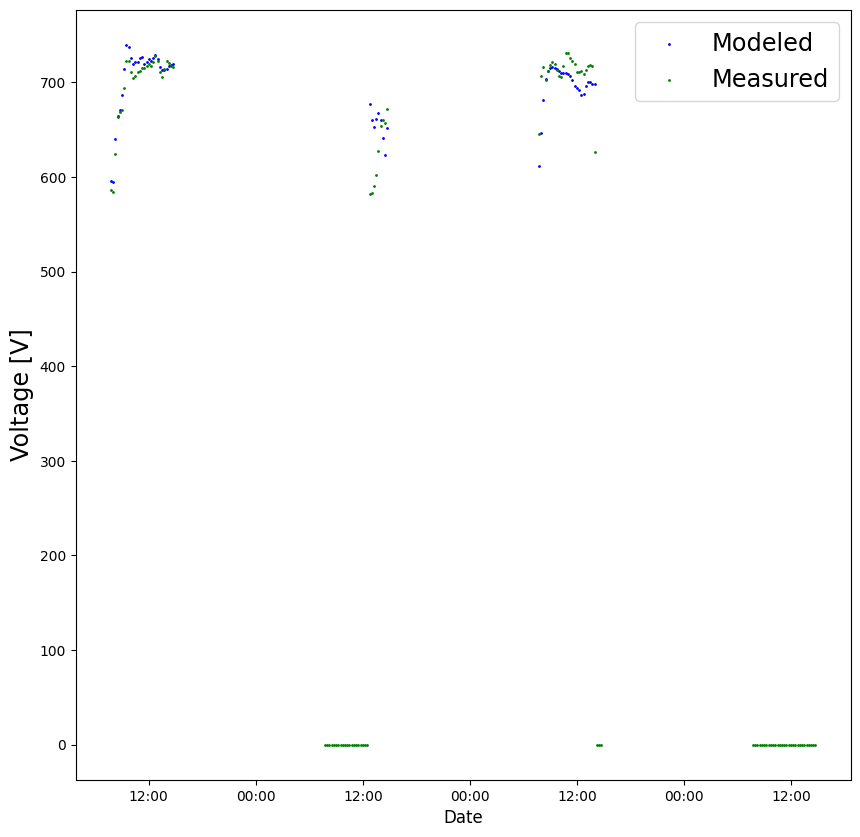

In [48]:
# %% Plot modeled and measured voltage
fig, ax = plt.subplots(figsize=(10,10))                             
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
temp = data['2022-01-06 07:45:00': '2022-01-09 17:45:00']
ax.scatter(temp.index, temp[name_modeled_vmp], s=1, c='b', label='Modeled')
ax.scatter(temp.index, temp[inv_cb + ' Voltage [V]'], s=1, c = 'g', label='Measured')
ax.legend(fontsize='xx-large')
ax.set_ylabel('Voltage [V]', fontsize='xx-large')
ax.set_xlabel('Date', fontsize='large')

In [49]:
def categorize(vmp_ratio, transmission, voltage, turn_on_voltage,
               threshold_vratio, threshold_transmission):
    
    """
    Categorizes electrical behavior into a snow-related or snow-free "mode"
    as defined in [1].

    Mode 0 = system is covered with enough opaque snow that the system is
    offline or its voltage is below the inverter's MPPT turn-on voltage
    Mode 1 = system is online and covered with non-uniform snow, such that
    both operating voltage and current are decreased by the presence of snow
    Mode 2 = system is online and covered with opaque snow, such that
    operating voltage is decreased by the presence of snow, but transmission
    is consistent with snow-free conditions
    Mode 3 = system is online and covered with light-transmissive snow, such
    that transmission is decreased but voltage is consistent with all
    system substrings being online
    Mode 4 = transmisison and voltage are consistent with snow-free conditions

    Parameters
    ----------
    vratio : float
        Ratio between measured voltage and voltage modeled using
        calculated values of transmission [dimensionless]
    transmission : float
        Fraction of irradiance measured by an onsite pyranometer that the
        array is able to utilize [dimensionless]
    voltage : float
        [V]
    turn_on_voltage : float
        The lower voltage bound on the inverter's maximum power point
        tracking (MPPT) algorithm [V]
    threshold_vratio : float
        The lower bound on vratio that is found under snow-free conditions,
        determined empirically
    threshold_transmission : float
        The lower bound on transmission that is found under snow-free
        conditions, determined empirically

    Returns
    -------
    mode : int

    [1] E. C. Cooper, J. L. Braid and L. M. Burnham, "Identifying the
    Electrical Signature of Snow in Photovoltaic Inverter Data," 2023 IEEE
    50th Photovoltaic Specialists Conference (PVSC), San Juan, PR, USA, 2023,
    pp. 1-5, doi: 10.1109/PVSC48320.2023.10360065.
    """
    
    if np.isnan(vmp_ratio) or np.isnan(transmission):
        return np.nan
    elif voltage < turn_on_voltage:
        return 0
    elif vmp_ratio < threshold_vratio:
        if transmission < threshold_transmission:
            return 1
        elif transmission > threshold_transmission:
            return 2
    elif vmp_ratio > threshold_vratio:
        if transmission < threshold_transmission:
            return 3
        elif transmission > threshold_transmission:
            return 4
    return np.nan

# %% Calculate transmission, model voltage, and categorize for given voltage, current pair

def wrapper(voltage, current, temp_cell, effective_irradiance,
            coeffs, config, temp_ref=25, irrad_ref=1000):
    
    '''
    voltage : array
        Voltage [V] measured at inverter
    current : array
        Current [A] measured at combiner
    temp_cell : array
        Cell temperature [degrees C]
    effective_irradiance : array
        Plane of array irradiance [W/m²] measured by a heated pyranometer
    coeffs : dict
        A dict defining the SAPM parameters, same as one used for pvlib.pvsystem.sapm
    config : dict
        turn_on_voltage : float
            The lower voltage bound on the inverter's maximum power point
            tracking (MPPT) algorithm [V]
        max_dcv : numeric
            Upper bound on MPPT algorithm [V]
        threshold_vratio : float
            The lower bound on vratio that is found under snow-free conditions,
            determined empirically
        threshold_transmission : float
            The lower bound on transmission that is found under snow-free
            conditions, determined empirically
        number_mods_per_str : int
        number_str_per_cb : int
    '''
    
    # Calculate transmission
    modeled_e_e = get_irradiance(temp_cell, current/config['number_str_per_cb'], coeffs['Impo'],
                                 coeffs['C0'], coeffs['C1'], coeffs['Aimp'], temp_ref=temp_ref)
    T = get_transmission(effective_irradiance/irrad_ref, modeled_e_e,
                         current/config['number_str_per_cb'])
    name_T = inv_cb + ' Transmission'
    data[name_T] = T

    # Model voltage for a single module, scale up to array
    modeled_vmp = pvlib.pvsystem.sapm(effective_irradiance*T, temp_cell, 
                                      coeffs)['v_mp']*config['number_mods_per_str']

    # Voltage is modeled as NaN if T = 0, but V = 0 makes more sense
    modeled_vmp[T == 0] = 0
    
    # Identify periods where modeled voltage is outside of MPPT range, and correct values
    modeled_vmp[modeled_vmp > config['max_dcv']] = np.nan
    modeled_vmp[modeled_vmp < config['min_dcv']] = 0

    # Calculate voltage ratio
    vmp_ratio = np.maximum(voltage/modeled_vmp, 0)
    vmp_ratio[modeled_vmp == 0] = 0

    categorize_v = np.vectorize(categorize)

    mode = categorize_v(vmp_ratio, T, voltage, config['min_dcv'],
                        config['threshold_vratio'], config['threshold_transmission'])
    my_dict = {'transmission' : T,
               'modeled_vmp' : modeled_vmp,
               'vmp_ratio' : vmp_ratio,
               'mode' : mode}
    
    return my_dict


In [50]:
# %% Demonstrate transmission, modeled voltage calculation and mode categorization on voltage, current pair
j = 0
v = dc_voltage_cols[j]
i = dc_current_cols[j]

# Used to get key for configuration dict
matched = re.match(r'INV(\d+) CB(\d+)', i)
inv_cb = matched.group(0)

# Number of strings connected in parallel to combiner
i_scaling_factor = int(config['num_str_per_cb'][f'{inv_cb}'])
threshold_vratio, threshold_t = 0.9331598025404861, 0.5976185185741869

my_config = {'threshold_vratio' : threshold_vratio,
             'threshold_transmission' : threshold_t,
             'min_dcv' : float(config['min_dcv']),
             'max_dcv' : float(config['max_dcv']),
             'number_str_per_cb' : int(config['num_str_per_cb'][f'{inv_cb}']),
             'number_mods_per_str' : int(config['num_mods_per_str'][f'{inv_cb}'])}

out = wrapper(data[v].values, data[i].values,
              data['Cell Temp [C]'].values,
              data['POA [W/m²]'].values, coeffs,
              my_config)


c:\Users\eccoope\pvanalyticsenv\Lib\site-packages\pvlib\pvsystem.py:2247: RuntimeWarning: invalid value encountered in add
  module['Vmpo'] +
C:\Users\eccoope\AppData\Local\Temp\ipykernel_19816\1597020725.py:118: RuntimeWarning: invalid value encountered in divide
  vmp_ratio = np.maximum(voltage/modeled_vmp, 0)


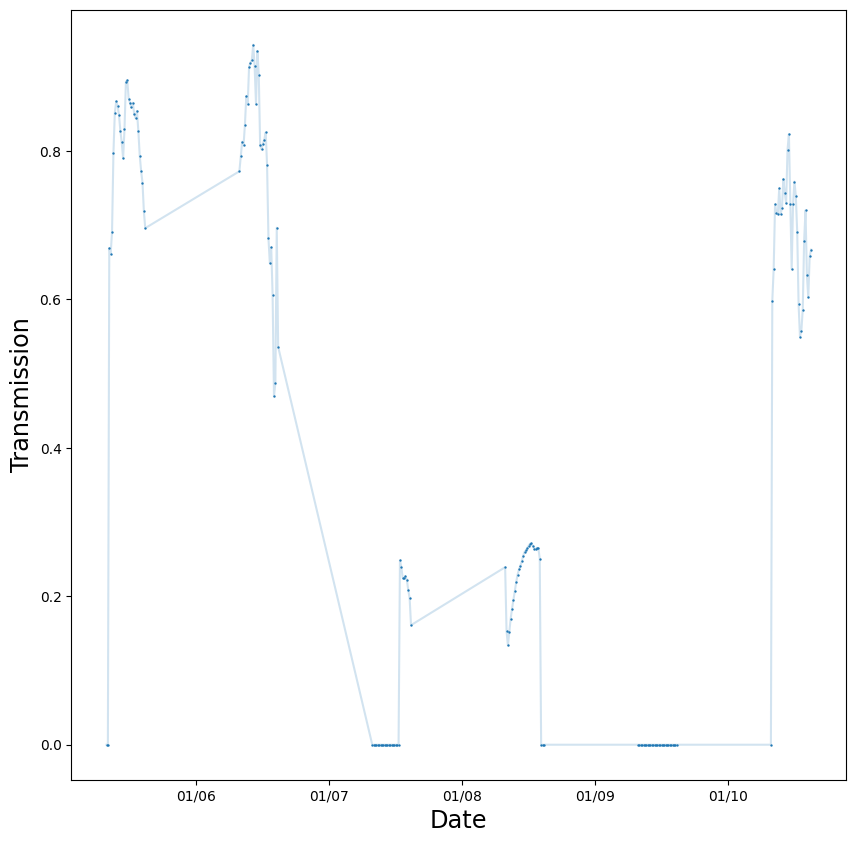

In [51]:
# Look at transmission
fig, ax = plt.subplots(figsize=(10,10))                             
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.scatter(data.index, out['transmission'], s=0.5)
ax.plot(data.index, out['transmission'], alpha=0.2)
ax.set_ylabel('Transmission', fontsize='xx-large')
ax.set_xlabel('Date', fontsize='xx-large');

In [52]:
# %% Calculate transmission, model voltage, and categorize into modes for all pairs of DC inputs

for v_col, i_col in zip(dc_voltage_cols, dc_current_cols):
    
    matched = re.match(r'INV(\d+) CB(\d+) Current', i_col)
    inv_num = matched.group(1)
    cb_num = matched.group(2)
    inv_cb = f'INV{inv_num} CB{cb_num}' 
    
    v_scaling_factor = int(config['num_mods_per_str'][inv_cb])
    i_scaling_factor = int(config['num_str_per_cb'][f'INV{inv_num} CB{cb_num}'])
    
    my_config = {'threshold_vratio' : threshold_vratio,
             'threshold_transmission' : threshold_t,
             'min_dcv' : float(config['min_dcv']),
             'max_dcv' : float(config['max_dcv']),
             'number_str_per_cb' : int(config['num_str_per_cb'][f'{inv_cb}']),
             'number_mods_per_str' : int(config['num_mods_per_str'][f'{inv_cb}'])}
    
    out = wrapper(data[v_col].values, data[i_col].values,
              data['Cell Temp [C]'].values,
              data['POA [W/m²]'].values, coeffs,
              my_config)
    
    for k, v in out.items():
        data[inv_cb + ' ' + k] = v


C:\Users\eccoope\AppData\Local\Temp\ipykernel_19816\1597020725.py:118: RuntimeWarning: invalid value encountered in divide
  vmp_ratio = np.maximum(voltage/modeled_vmp, 0)
C:\Users\eccoope\AppData\Local\Temp\ipykernel_19816\1597020725.py:118: RuntimeWarning: divide by zero encountered in divide
  vmp_ratio = np.maximum(voltage/modeled_vmp, 0)


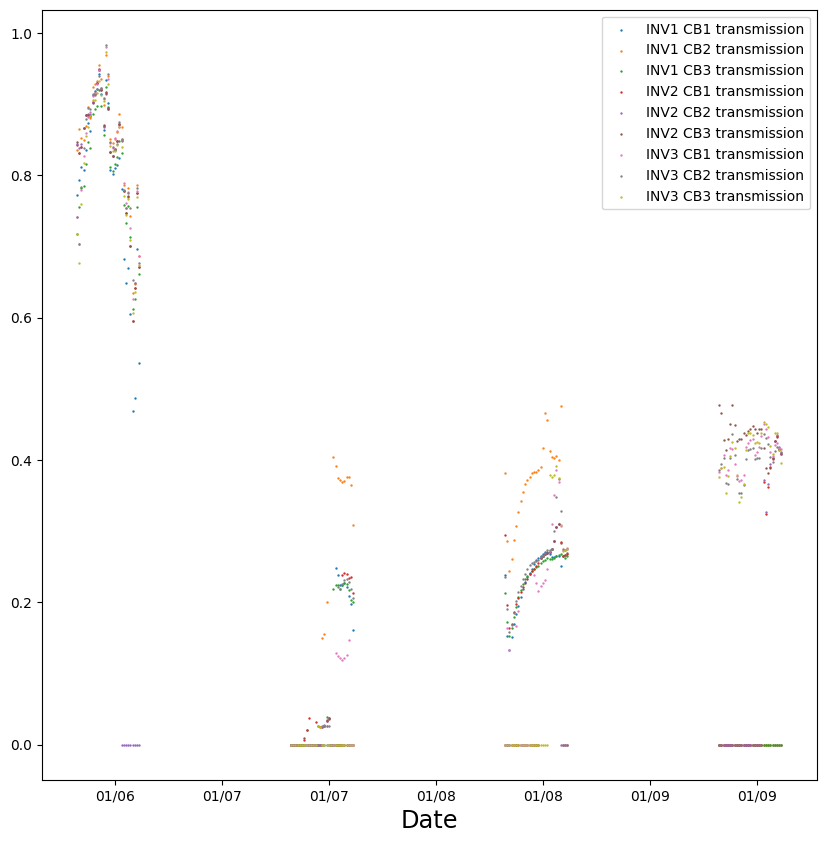

In [53]:
# Look at transmission for all DC inputs
transmission_cols = [c for c in data.columns if 'transmission' in c]
fig, ax = plt.subplots(figsize=(10,10))                             
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
temp = data['2022-01-06 07:45:00': '2022-01-09 17:45:00']

for c in transmission_cols:
    ax.scatter(temp.index, temp[c], s=0.5, label=c)
ax.set_xlabel('Date', fontsize='xx-large')
ax.legend()

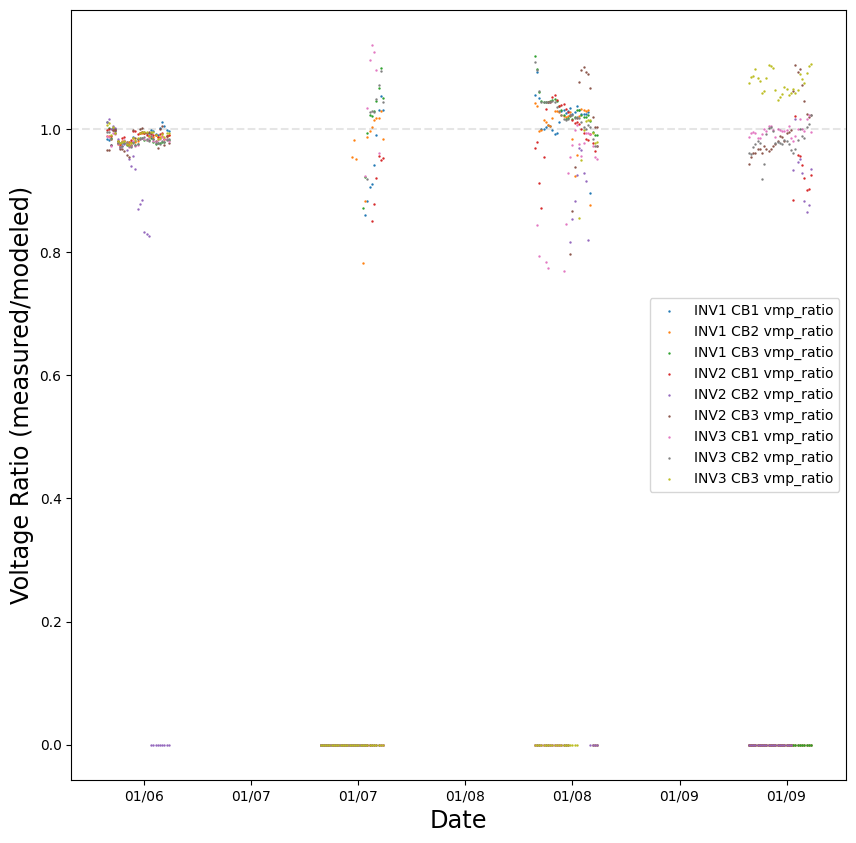

In [54]:
#%% Look at voltage ratios for all DC inputs
vratio_cols = [c for c in data.columns if "vmp_ratio" in c]
fig, ax = plt.subplots(figsize=(10,10))                             
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
temp = data['2022-01-06 07:45:00': '2022-01-09 17:45:00']

for c in vratio_cols:
    ax.scatter(temp.index, temp[c], s=0.5, label=c)

ax.set_xlabel('Date', fontsize='xx-large')
ax.set_ylabel('Voltage Ratio (measured/modeled)', fontsize='xx-large')
ax.axhline(1, c='k', alpha=0.1, ls='--')
ax.legend();

In [55]:
# Calculate all power losses - snow and non-snow 

modeled_df = pvlib.pvsystem.sapm(data['POA [W/m²]'],
                                 data['Cell Temp [C]'],
                                 coeffs)

for v_col, i_col in zip(dc_voltage_cols, dc_current_cols):
    matched = re.match(r'INV(\d+) CB(\d+) Current', i_col)
    inv_num = matched.group(1)
    cb_num = matched.group(2)
    inv_cb = f'INV{inv_num} CB{cb_num}'
    i_scaling_factor = int(config['num_str_per_cb'][f'INV{inv_num} CB{cb_num}'])
    v_scaling_factor = int(config['num_mods_per_str'][inv_cb])

    modeled_power = modeled_df['p_mp']*v_scaling_factor*i_scaling_factor
    name_modeled_power = inv_cb + ' Modeled Power [W]'
    data[name_modeled_power] = modeled_power

    name_loss = inv_cb + ' Loss [W]'
    loss = np.maximum(data[name_modeled_power] - data[i_col]*data[v_col], 0)
    data[name_loss] = loss

In [56]:

snow = pd.read_csv(snow_path, index_col='DATE')

Plot daily losses and snowfall

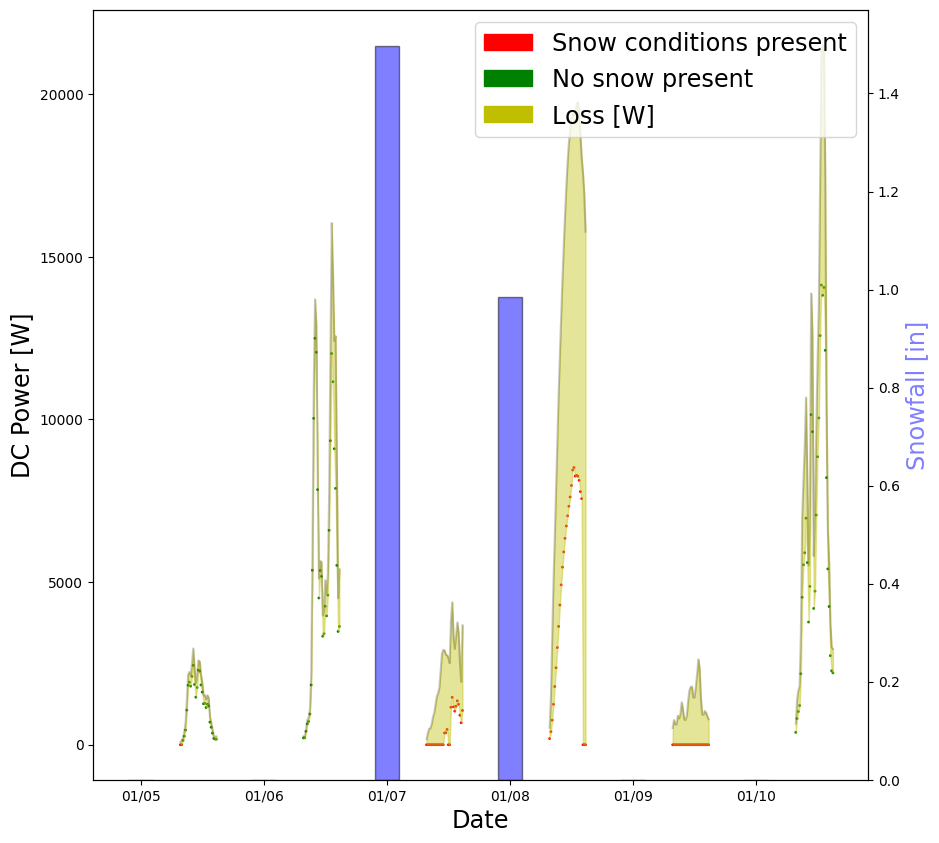

In [57]:
# %% Plot power losses, color points by mode

loss_cols = [c for c in data.columns if "Loss" in c]
mode_cols = [c for c in data.columns if "mode" in c and "modeled" not in c]
modeled_power_cols = [c for c in data.columns if "Modeled Power" in c]

i = 1
l = loss_cols[i]
m = mode_cols[i]
p = modeled_power_cols[i]

# (Green = no snow, Red = snow)
cmap = {0 : 'r',
        1: 'r',
        2: 'r',
        3: 'r',
        4: 'g'}

fig, ax = plt.subplots(figsize=(10,10))                             
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
temp = data[~data[m].isna()]

# Plot each day individually so we are not exaggerating losses
days_mapped = temp.index.map(lambda x : x.date())
days = np.unique(days_mapped)
grouped = temp.groupby(days_mapped)

for d in days:
        temp_grouped = grouped.get_group(d)
        ax.plot(temp_grouped.index, temp_grouped[p], c='k', alpha=0.2)
        ax.scatter(temp_grouped.index, temp_grouped[p] - temp_grouped[l], c=temp_grouped[m].map(cmap), s=1)
        ax.fill_between(temp_grouped.index, temp_grouped[p] - temp_grouped[l], temp_grouped[p], color='y', alpha=0.4)

# Add different colored points to legend
handles, labels = ax.get_legend_handles_labels()
red_patch = mpatches.Patch(color='r', label='Snow conditions present')
green_patch = mpatches.Patch(color='g', label='No snow present')
yellow_patch = mpatches.Patch(color='y', label='Loss [W]')
handles.append(red_patch) 
handles.append(green_patch)
handles.append(yellow_patch)

ax.set_xlabel('Date', fontsize='xx-large')
ax.set_ylabel('DC Power [W]', fontsize='xx-large')
ax.legend(handles=handles, fontsize='xx-large', loc='upper right')

ax2 = ax.twinx()
ax2.bar(days, snow['SNOW'].values/(10*2.54), color='b', alpha=0.5, width=0.2, ec='k')
ax2.set_ylabel('Snowfall [in]', c='b', fontsize='xx-large', alpha=0.5);


Calculate daily snow losses

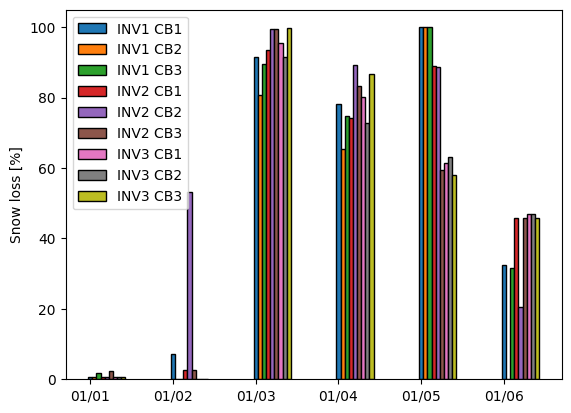

In [58]:
loss_cols = [c for c in data.columns if "Loss" in c]
mode_cols = [c for c in data.columns if "mode" in c and "modeled" not in c]
modeled_power_cols = [c for c in data.columns if "Modeled Power" in c]

days_mapped = data.index.map(lambda x: x.date())
days = np.unique(days_mapped)
data_gped = data.groupby(days_mapped)

columns = [re.match(r'INV(\d) CB(\d)', c).group(0) for c in loss_cols]

snow_loss = pd.DataFrame(index=days, columns=columns)

for d in days:
    temp = data_gped.get_group(d)

    for c, m, l, p in zip(columns, mode_cols, loss_cols, modeled_power_cols):
        daily_snow_loss = 100*(temp[(~temp[m].isna()) & (temp[m] != 4)][l].sum()/temp[p].sum())
        snow_loss.at[d, c] = daily_snow_loss


fig, ax = plt.subplots()
date_form = DateFormatter("%m/%d")

days_mapped = data.index.map(lambda x: x.date())
days = np.unique(days_mapped)

xvals = np.arange(0, len(days), 1)
xwidth = 0.05
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, c in enumerate(columns):
    ax.bar(xvals + xwidth*i, snow_loss[c], width=xwidth, color=colors[i], ec='k', label=c)

ax.legend()
ax.set_ylabel('Snow loss [%]')
ax.set_xticks(xvals, days)
ax.xaxis.set_major_formatter(date_form);       
